# STURM-Flood Inference & Visualization Notebook

This notebook performs flood extent inference on Sentinel-1 and Sentinel-2 tiles using pretrained U-Net models, and computes metrics when ground-truth is available.

Models and datasets are available on Zenodo:
- Sentinel-1: [DOI:10.5281/zenodo.15189664](https://doi.org/10.5281/zenodo.15189664)
- Sentinel-2: [DOI:10.5281/zenodo.15189633](https://doi.org/10.5281/zenodo.15189633)
- Dataset: [DOI:10.5281/zenodo.12748982](https://doi.org/10.5281/zenodo.12748982)

# Import dependencies

In [1]:
import os
import sys


from tqdm import tqdm

import numpy as np

import pandas as pd
import requests

# Functions

In [2]:
# Add U-Net architecture path and import model
arch_dir = './arch'
sys.path.append(arch_dir)
from model import unet_model

def rebuild_model(params):
    model = unet_model(
        n_classes=2,
        tile_width=params['input_shape'][0],
        tile_height=params['input_shape'][1],
        n_bands=params['input_shape'][2],
        n_blocks=params['n_blocks'],
        class_weight_list=[1, 1],
        normalize_inputs=False
    )
    model.load_weights(params['weights_path'])
    return model

In [3]:
sys.path.append('./utils')
from utils.io import download_from_zenodo, extract_tarfile, extract_zipfile
from utils.inference_metrics import run_inference
from utils.visualization import save_visualizations

# Sturm-Flood dataset download

In [ ]:
# Dataset URL and destination
dataset_url = "https://zenodo.org/records/12748983/files/Dataset.zip"
dataset_dir = './STURM-Flood'
os.makedirs(dataset_dir, exist_ok=True)
dataset_zip_path = os.path.join(dataset_dir, "STURM-Flood.zip")

# Download dataset archive
download_from_zenodo(dataset_url, dataset_zip_path)

# Extract ZIP archive
extract_zipfile(dataset_zip_path, dataset_dir)


# U-Net setup

In [6]:
# Directories for pretrained models
s1_model_dir = './unet/sentinel1_model'
s2_model_dir = './unet/sentinel2_model'
os.makedirs(s1_model_dir, exist_ok=True)
os.makedirs(s2_model_dir, exist_ok=True)

# Download pretrained models from Zenodo
s1_model_url = "https://zenodo.org/records/15189665/files/S1_model.tar.gz"
s2_model_url = "https://zenodo.org/records/15189634/files/S2_model.tar.gz"

s1_model_tar = os.path.join(s1_model_dir, 'model.tar.gz')
s2_model_tar = os.path.join(s2_model_dir, 'model.tar.gz')

download_from_zenodo(s1_model_url, s1_model_tar)
download_from_zenodo(s2_model_url, s2_model_tar)

# Extract the downloaded tar files
extract_tarfile(s1_model_tar, s1_model_dir)
extract_tarfile(s2_model_tar, s2_model_dir)

In [5]:
# Model parameters and data directories
model_params = {
    'Sentinel-1': {
        'input_shape': (128, 128, 2),
        'n_blocks': 6,
        'weights_path': os.path.join(s1_model_dir, 'unet/1/model_weights.hdf5')
    },
    'Sentinel-2': {
        'input_shape': (128, 128, 9),
        'n_blocks': 5,
        'weights_path': os.path.join(s2_model_dir, 'unet/1/model_weights.hdf5')
    }
}

In [8]:
# Rebuild models
s1_model = rebuild_model(model_params['Sentinel-1'])
s2_model = rebuild_model(model_params['Sentinel-2'])

# Inference

## Data and metadata

In [9]:
# Define directories for composites, masks, and output predictions
composite_dirs = {
    'Sentinel-1': "./STURM-Flood/Dataset/Sentinel1/S1",
    'Sentinel-2': "./STURM-Flood/Dataset/Sentinel2/S2"
}

with_gt = True
mask_dirs = {
    'Sentinel-1': "./STURM-Flood/Dataset/Sentinel1/Floodmaps",
    'Sentinel-2': "./STURM-Flood/Dataset/Sentinel2/Floodmaps"
}

output_dir = './inference_results'
visualization_dir = './tile_visualizations'
os.makedirs(output_dir, exist_ok=True)
os.makedirs(visualization_dir, exist_ok=True)

# Load metadata
s1_metadata_path = "./STURM-Flood/Dataset/Sentinel1_metadata.csv"
s2_metadata_path = "./STURM-Flood/Dataset/Sentinel2_metadata.csv"

s1_metadata = pd.read_csv(s1_metadata_path)
s2_metadata = pd.read_csv(s2_metadata_path)

# Sample 10 tiles for quick testing (adjust as needed)
s1_test_df = s1_metadata.sample(n=5, random_state=42).reset_index(drop=True)
s2_test_df = s2_metadata.sample(n=5, random_state=42).reset_index(drop=True)

print(f"Sentinel-1: {len(s1_test_df)} test tiles loaded.")
print(f"Sentinel-2: {len(s2_test_df)} test tiles loaded.")



Sentinel-1: 5 test tiles loaded.
Sentinel-2: 5 test tiles loaded.


## Run Inference and collect metrics if ground-truth is available

In [ ]:

# Run inference and collect metrics

score_threshold = 0.5
results = []

for dataset, df, model in zip(
    ['Sentinel-1', 'Sentinel-2'],
    [s1_test_df, s2_test_df],
    [s1_model, s2_model]
):
    for _, row in tqdm(df.iterrows(), total=len(df), desc=f"Processing {dataset}"):
        tile = row['tile_id']
        metrics = run_inference(tile, dataset, model, composite_dirs, mask_dirs, output_dir, score_threshold, with_gt)
        if metrics:
            metrics['tile_id'] = tile
            metrics['Dataset'] = dataset
            results.append(metrics)

if with_gt:
    # Save evaluation results
    results_df = pd.DataFrame(results)
    results_df.to_csv('inference_metrics.csv', index=False)
    print("Inference completed. Metrics saved to 'inference_metrics.csv'.")
else:
    print("Inference completed. No metrics saved as 'with_gt' is set to False.")


Processing Sentinel-1:   0%|          | 0/5 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


Processing Sentinel-1:  20%|██        | 1/5 [00:00<00:01,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Processing Sentinel-1:  40%|████      | 2/5 [00:00<00:00,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Processing Sentinel-1:  60%|██████    | 3/5 [00:00<00:00,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Processing Sentinel-1:  80%|████████  | 4/5 [00:01<00:00,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Processing Sentinel-2:   0%|          | 0/5 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Processing Sentinel-2:  20%|██        | 1/5 [00:00<00:01,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Processing Sentinel-2:  40%|████      | 2/5 [00:00<00:00,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Processing Sentinel-2:  60%|██████    | 3/5 [00:00<00:00,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Processing Sentinel-2:  80%|████████  | 4/5 [00:00<00:00,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Processing Sentinel-2: 100%|██████████| 5/5 [00:01<00:00,  4.71it/s]

Inference completed. Metrics saved to 'inference_metrics.csv'.


## Visualize results and save visualizations

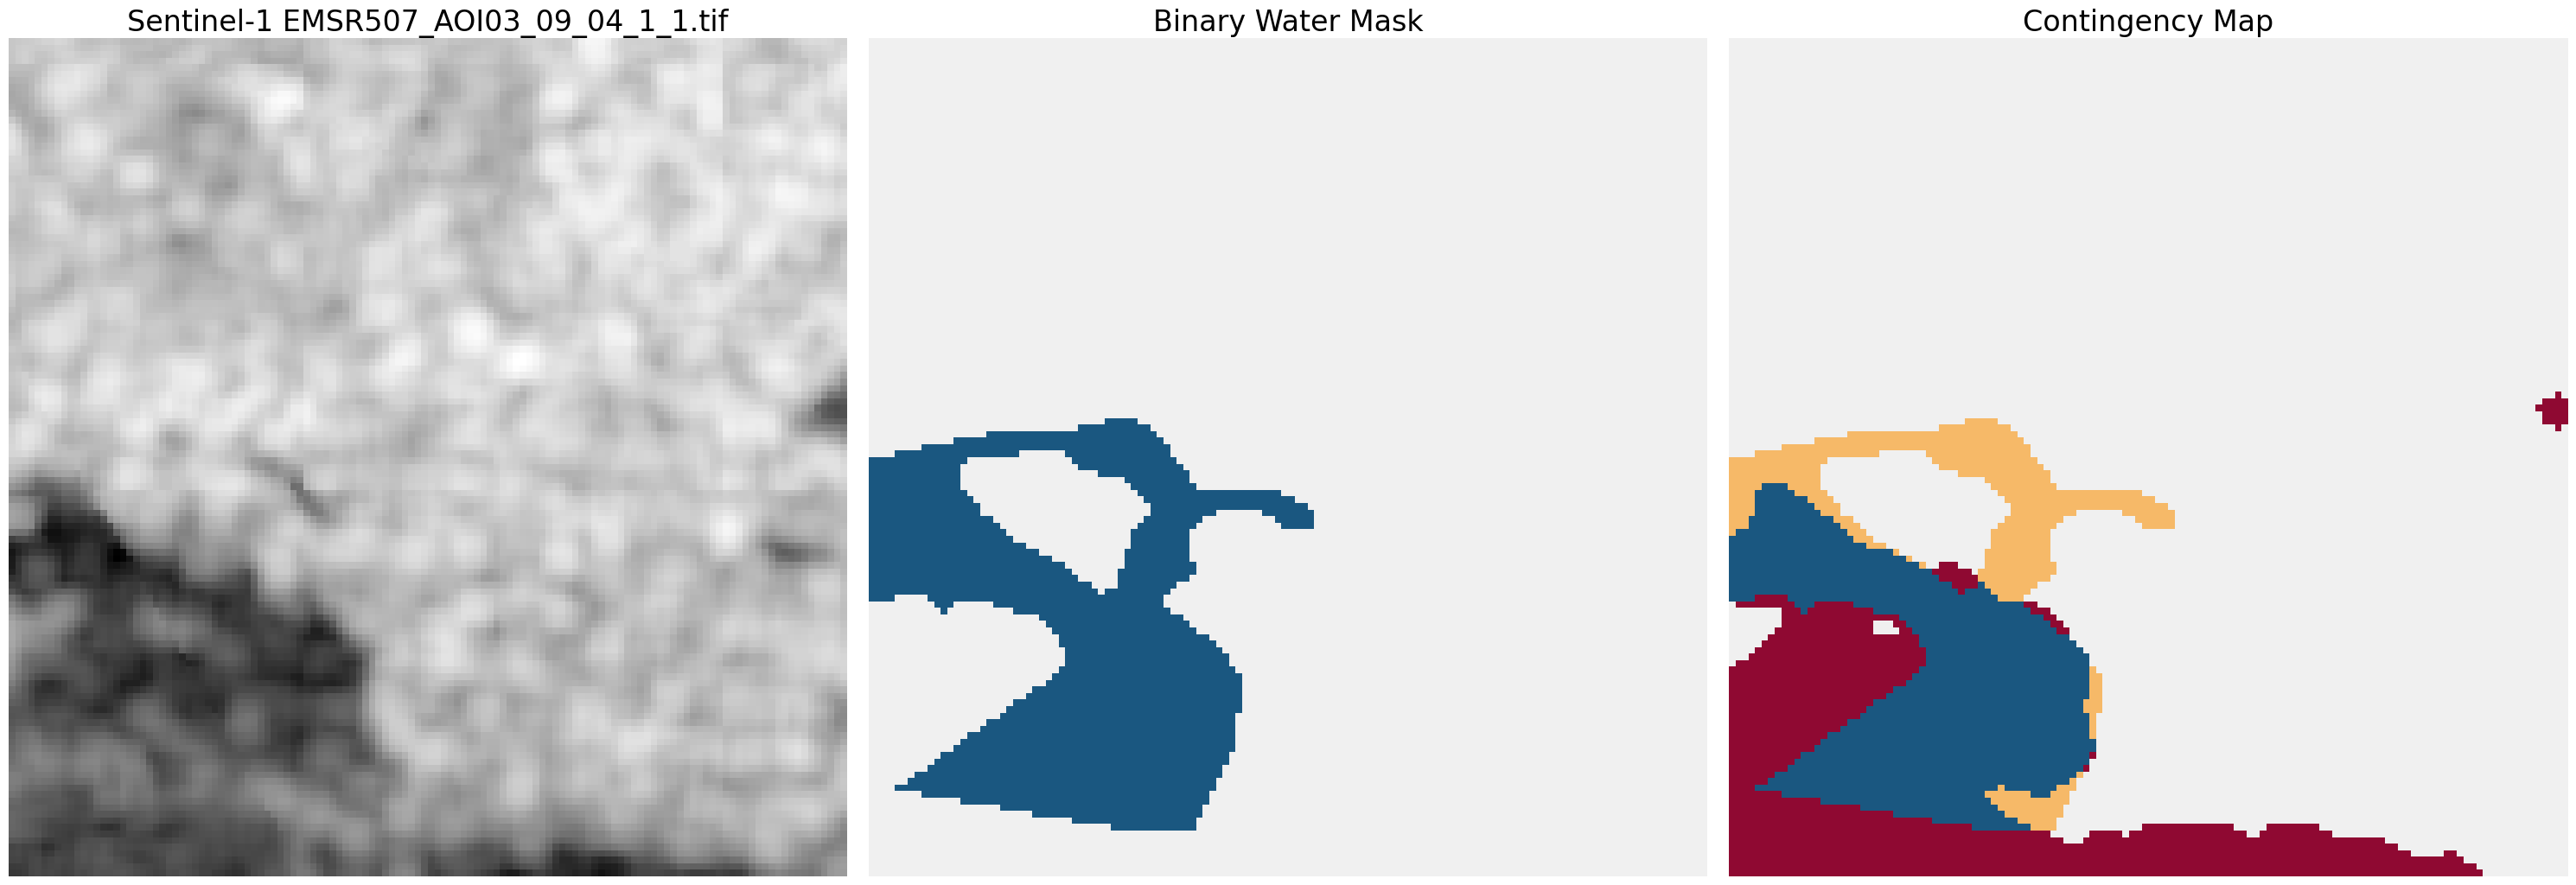

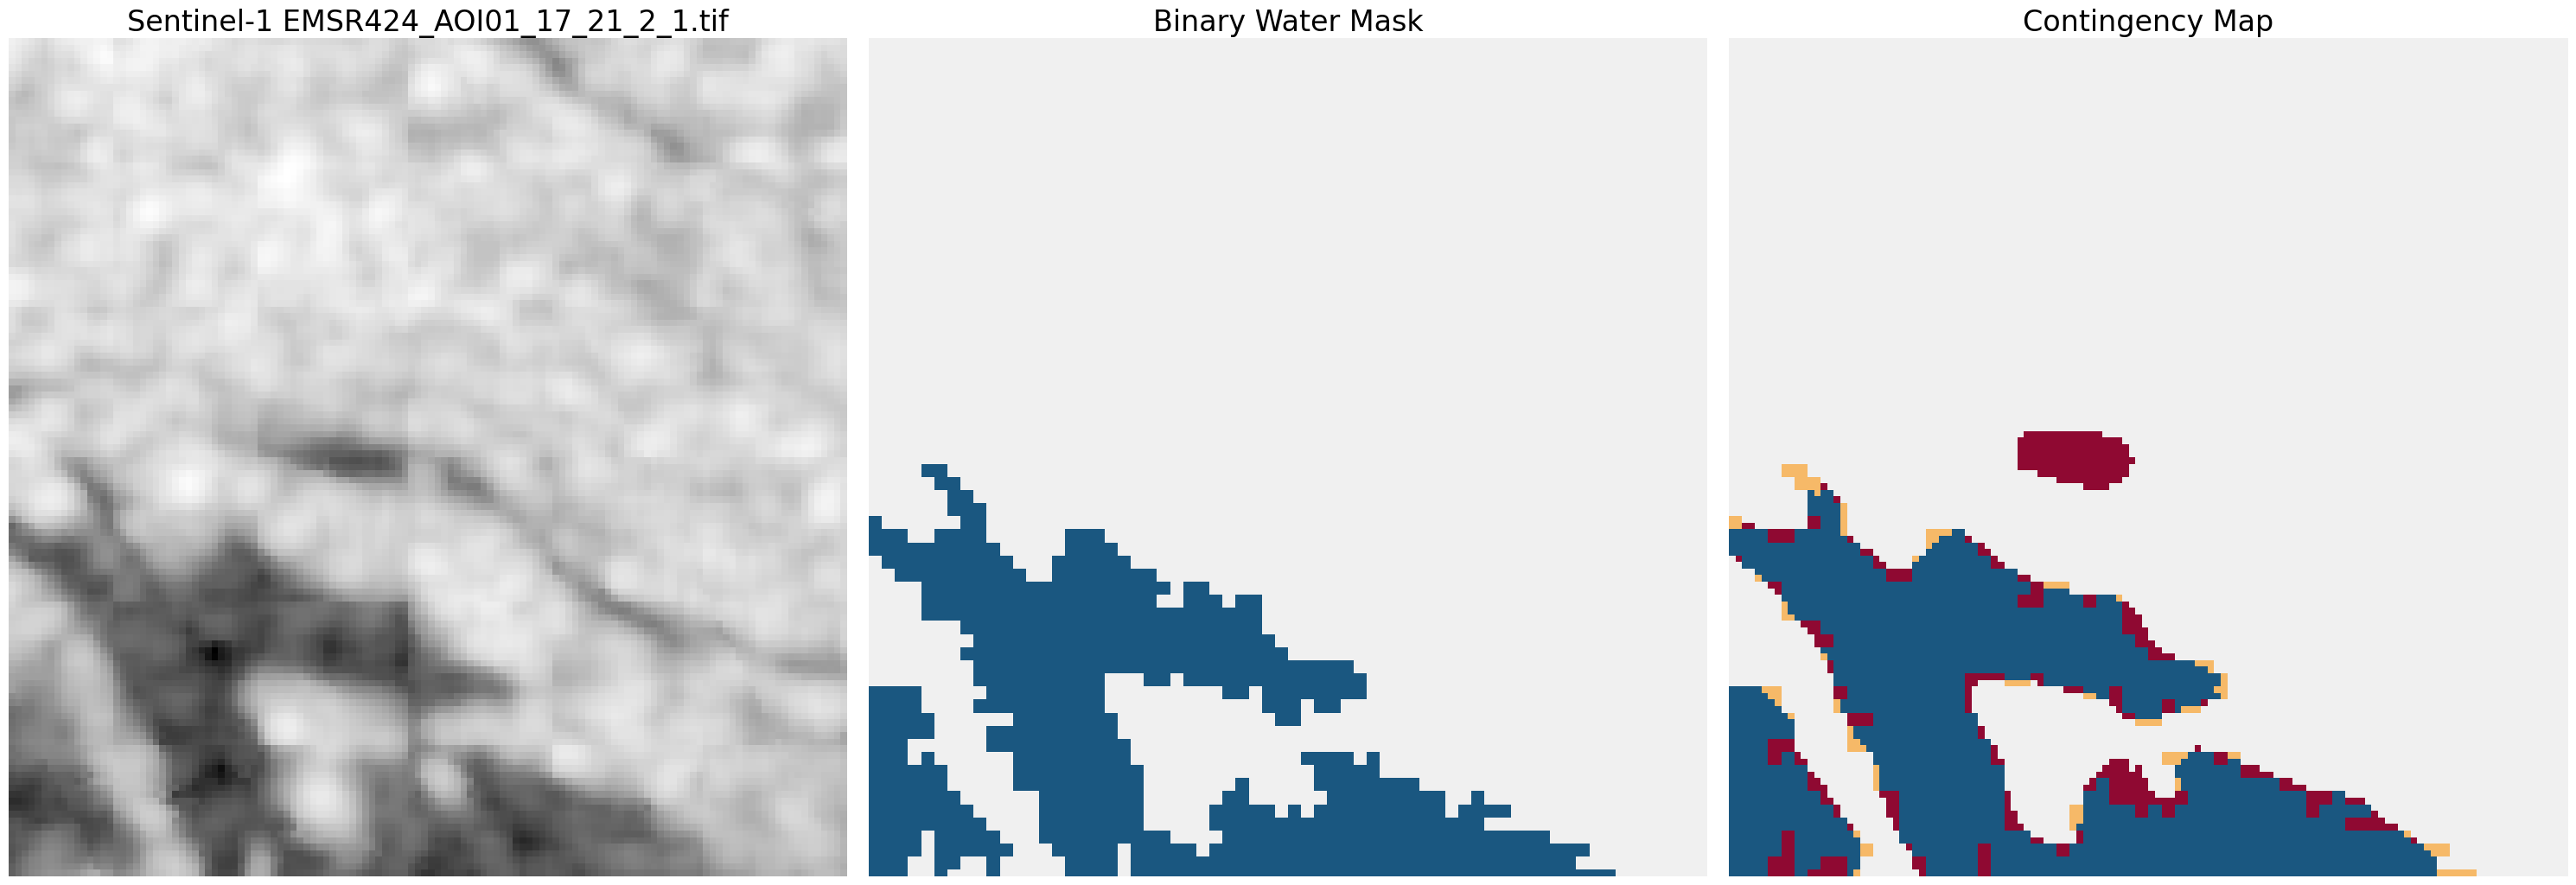

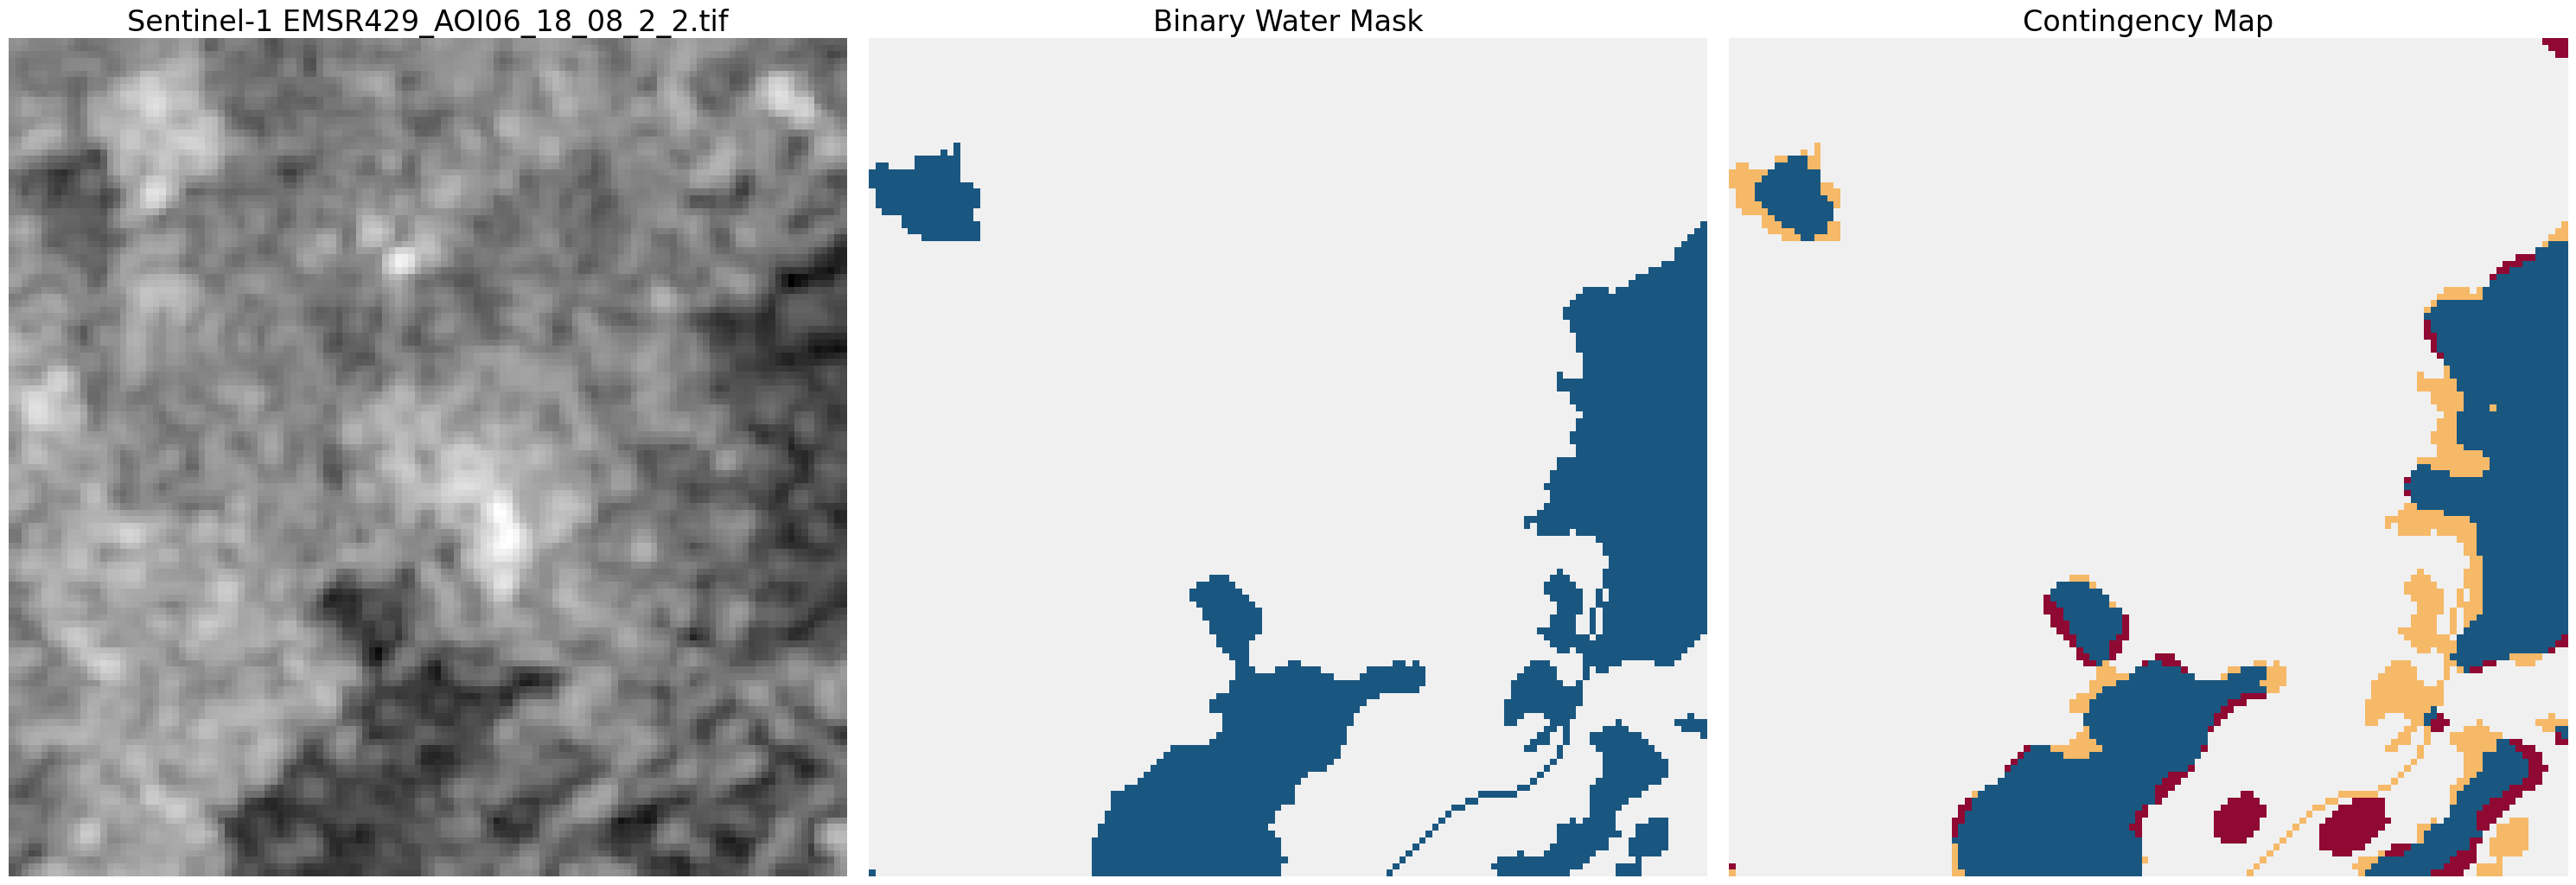

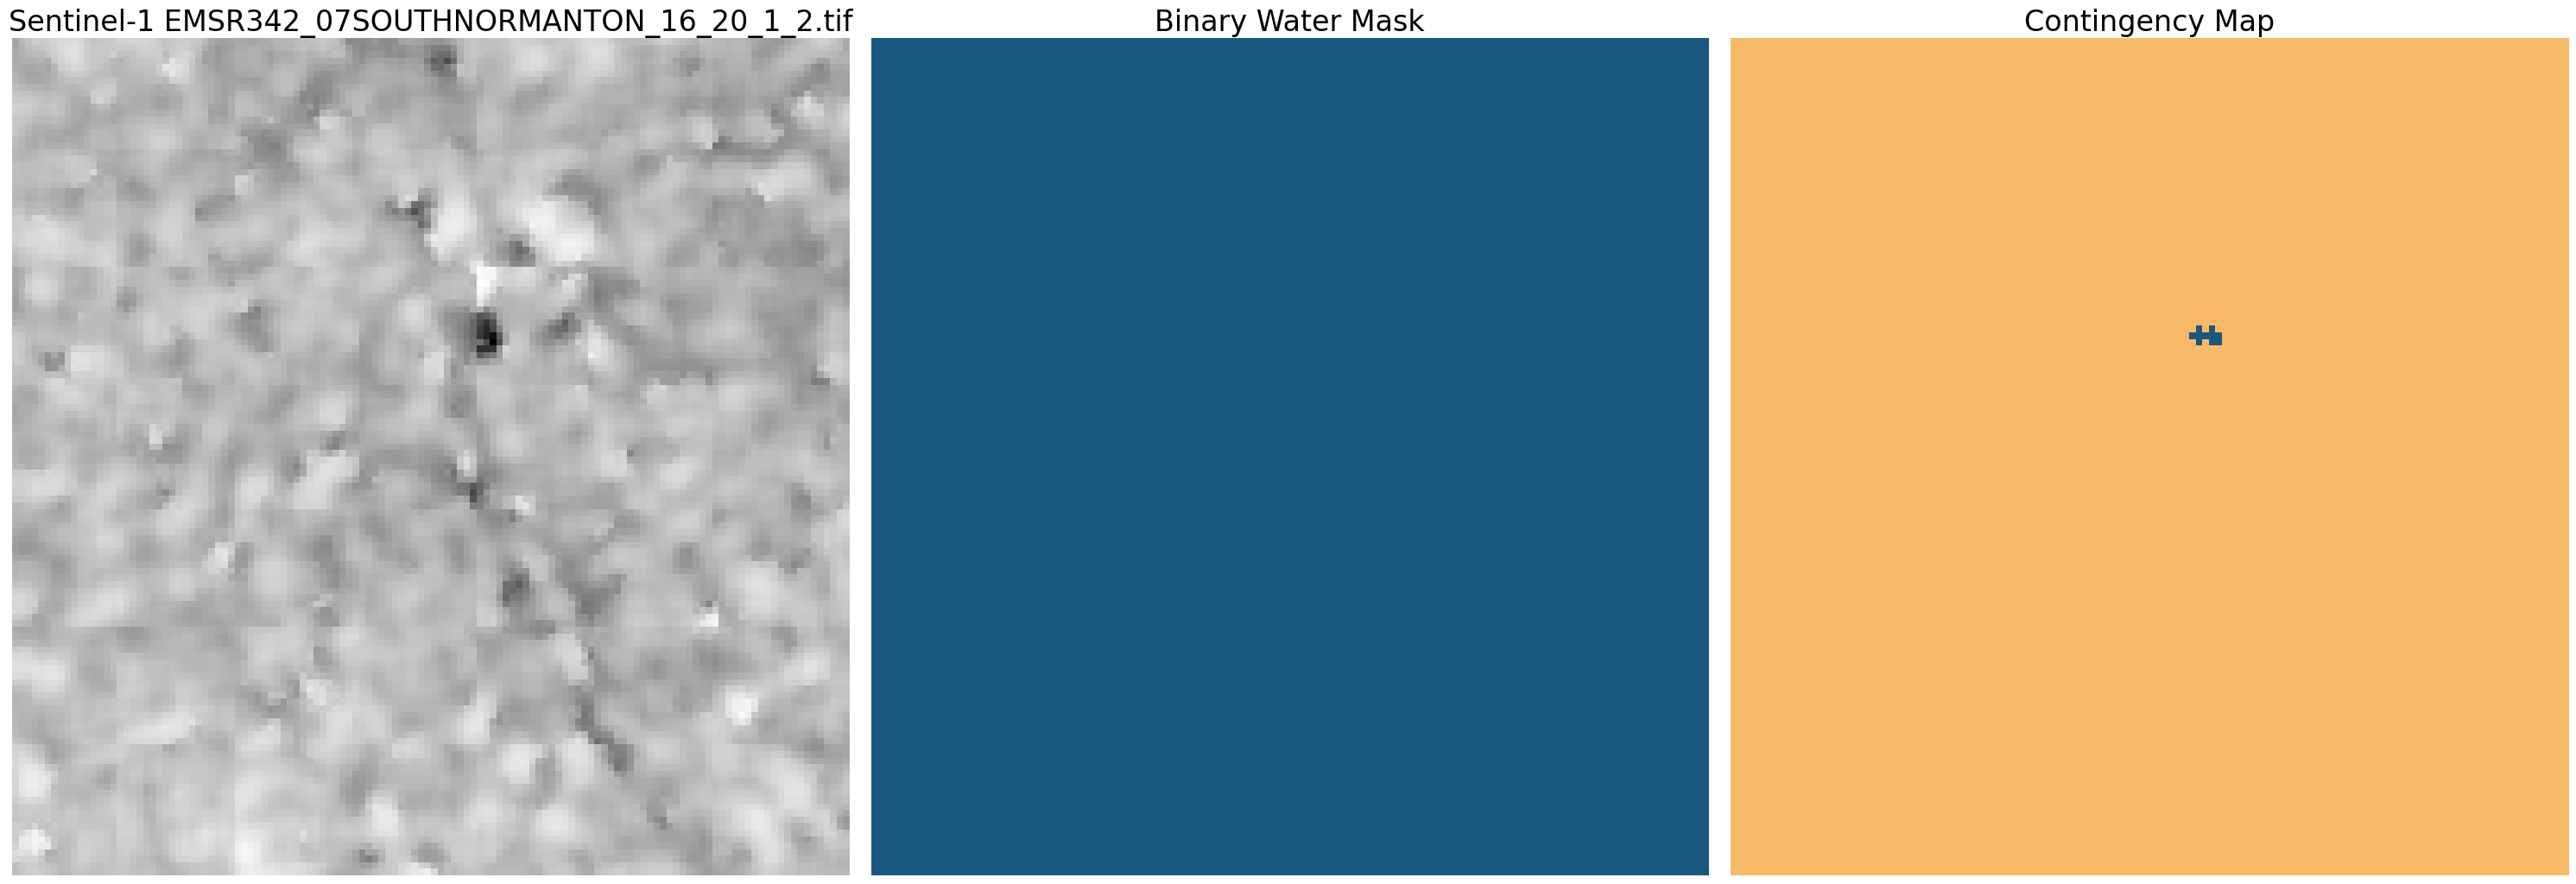

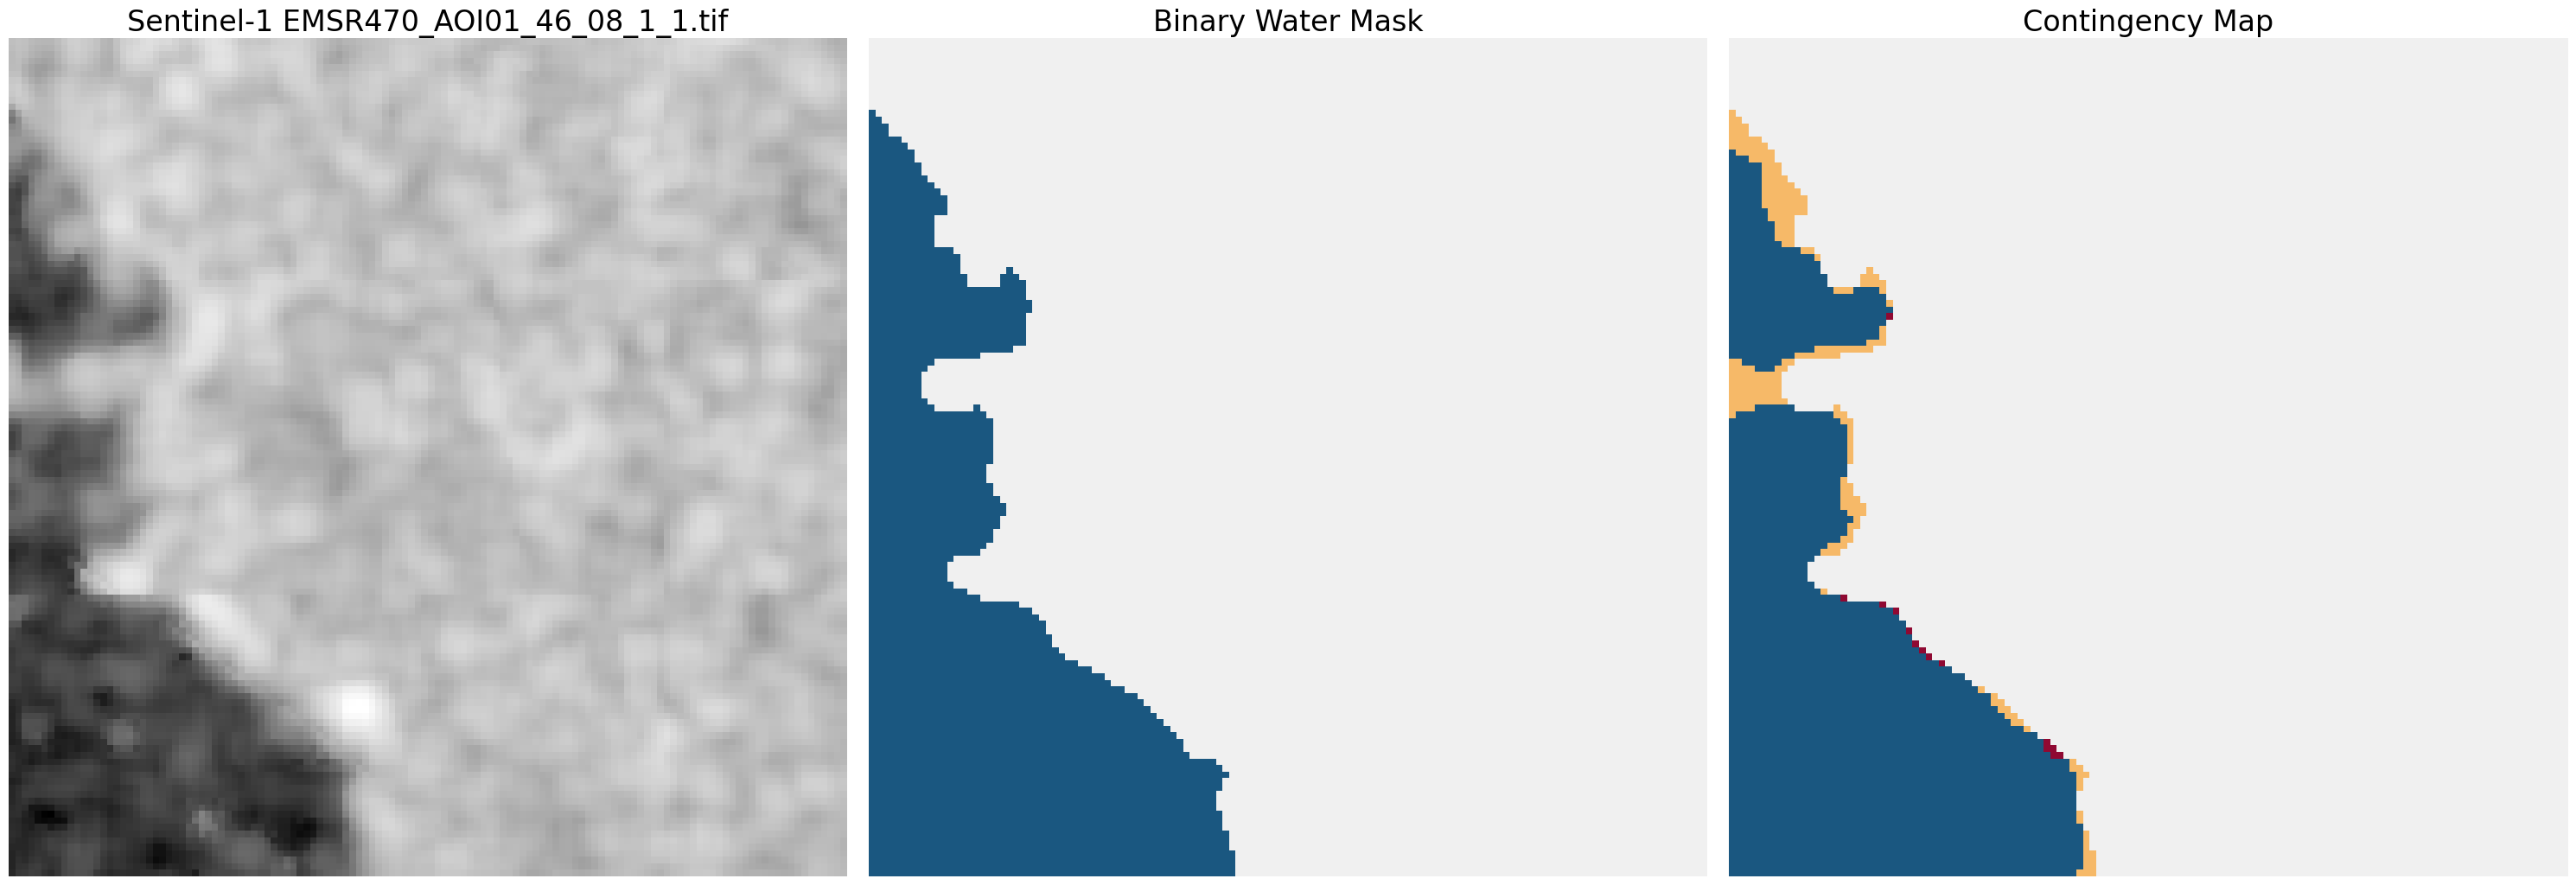

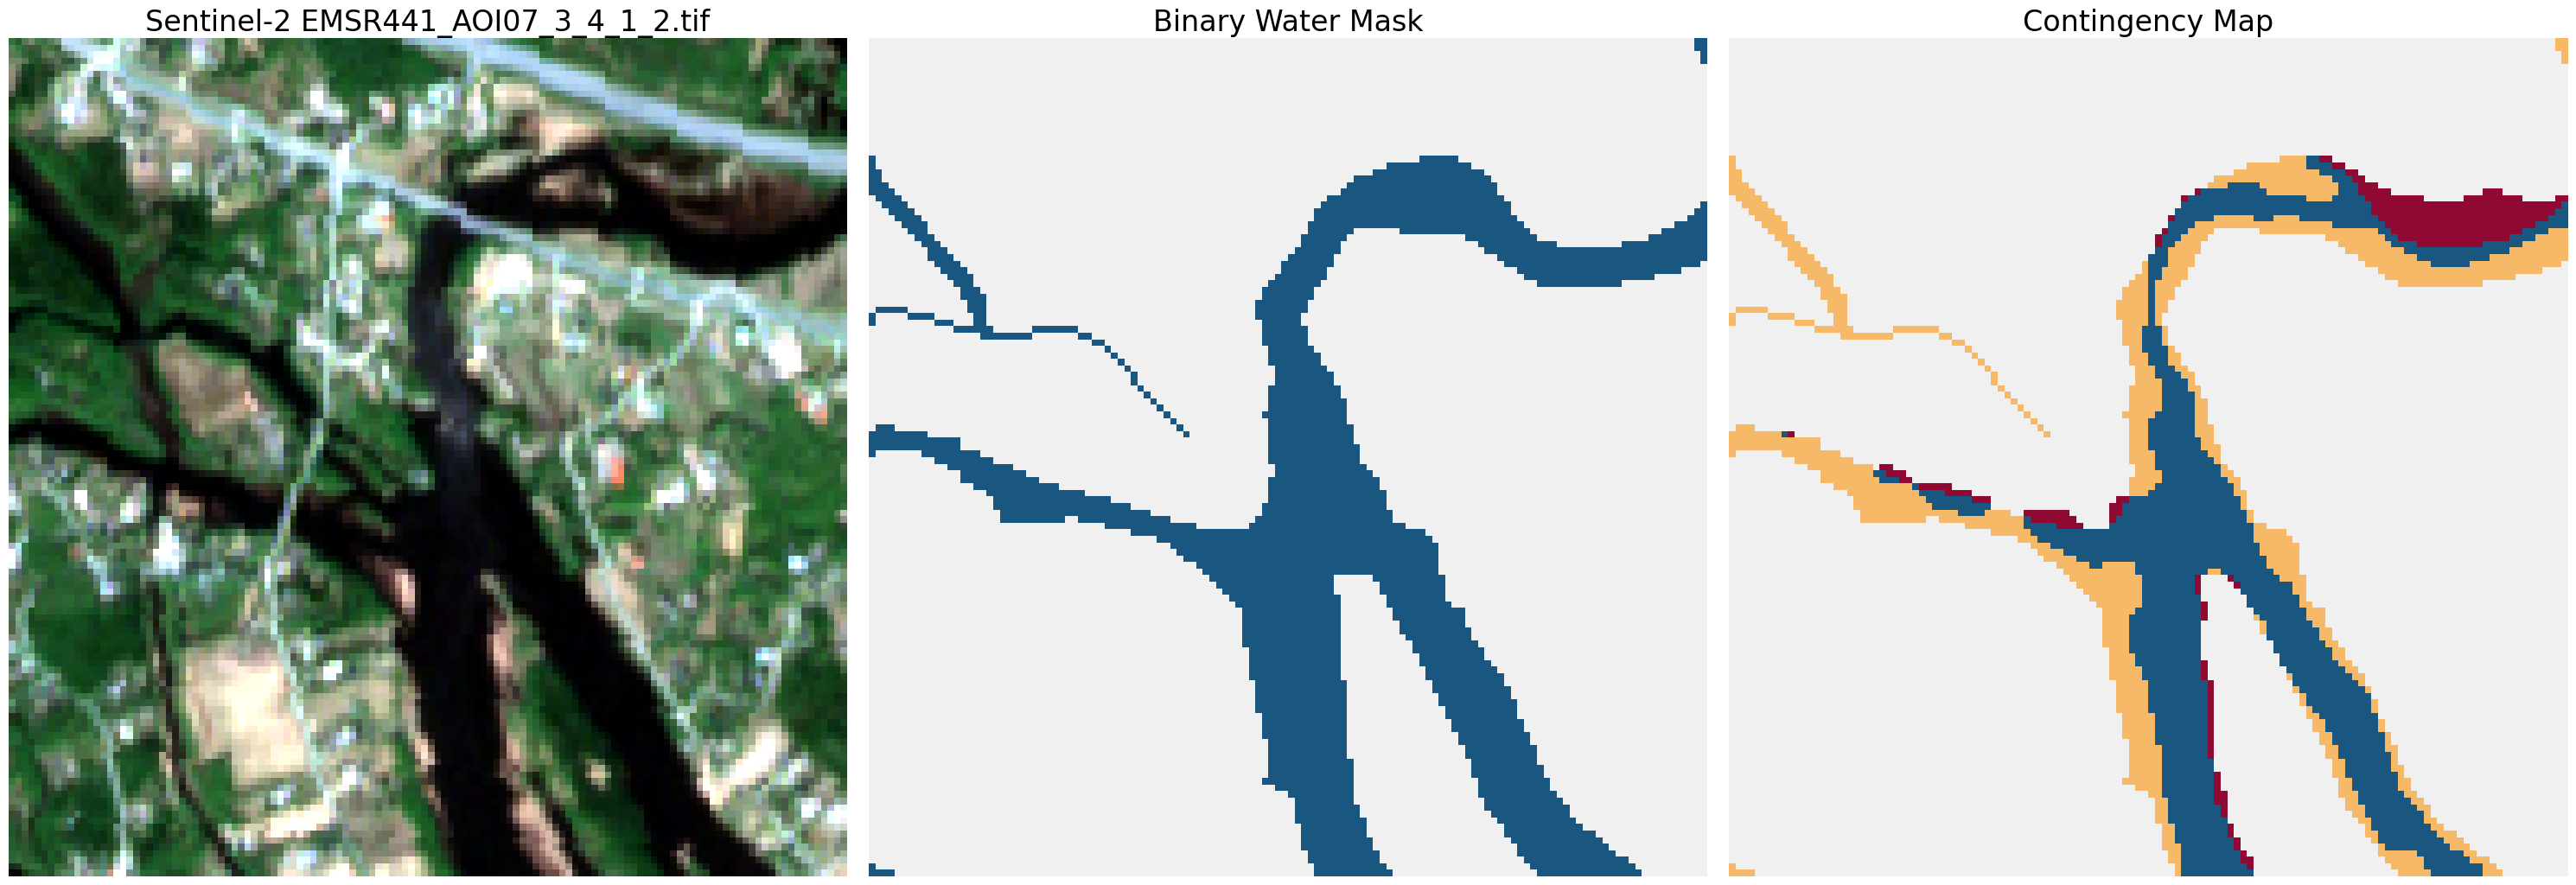

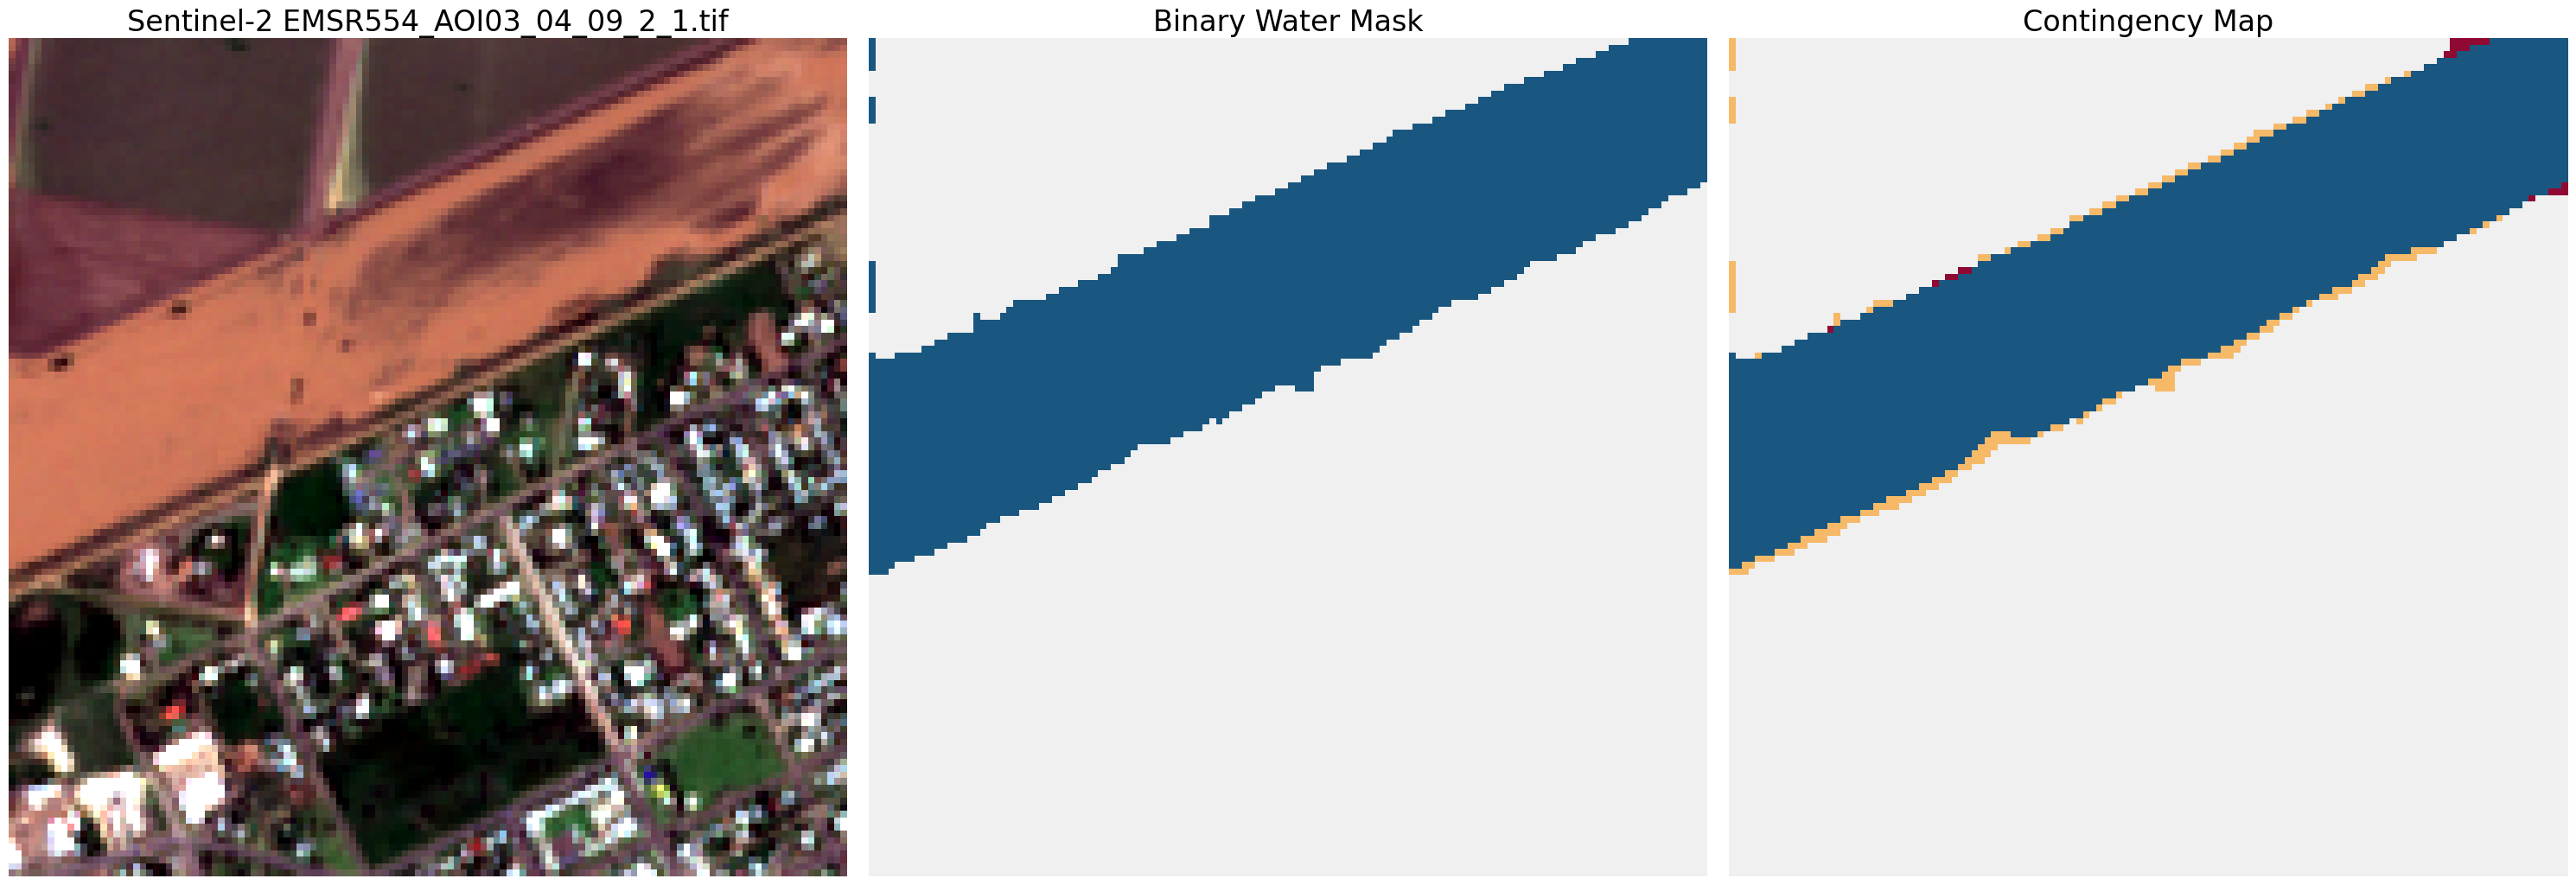

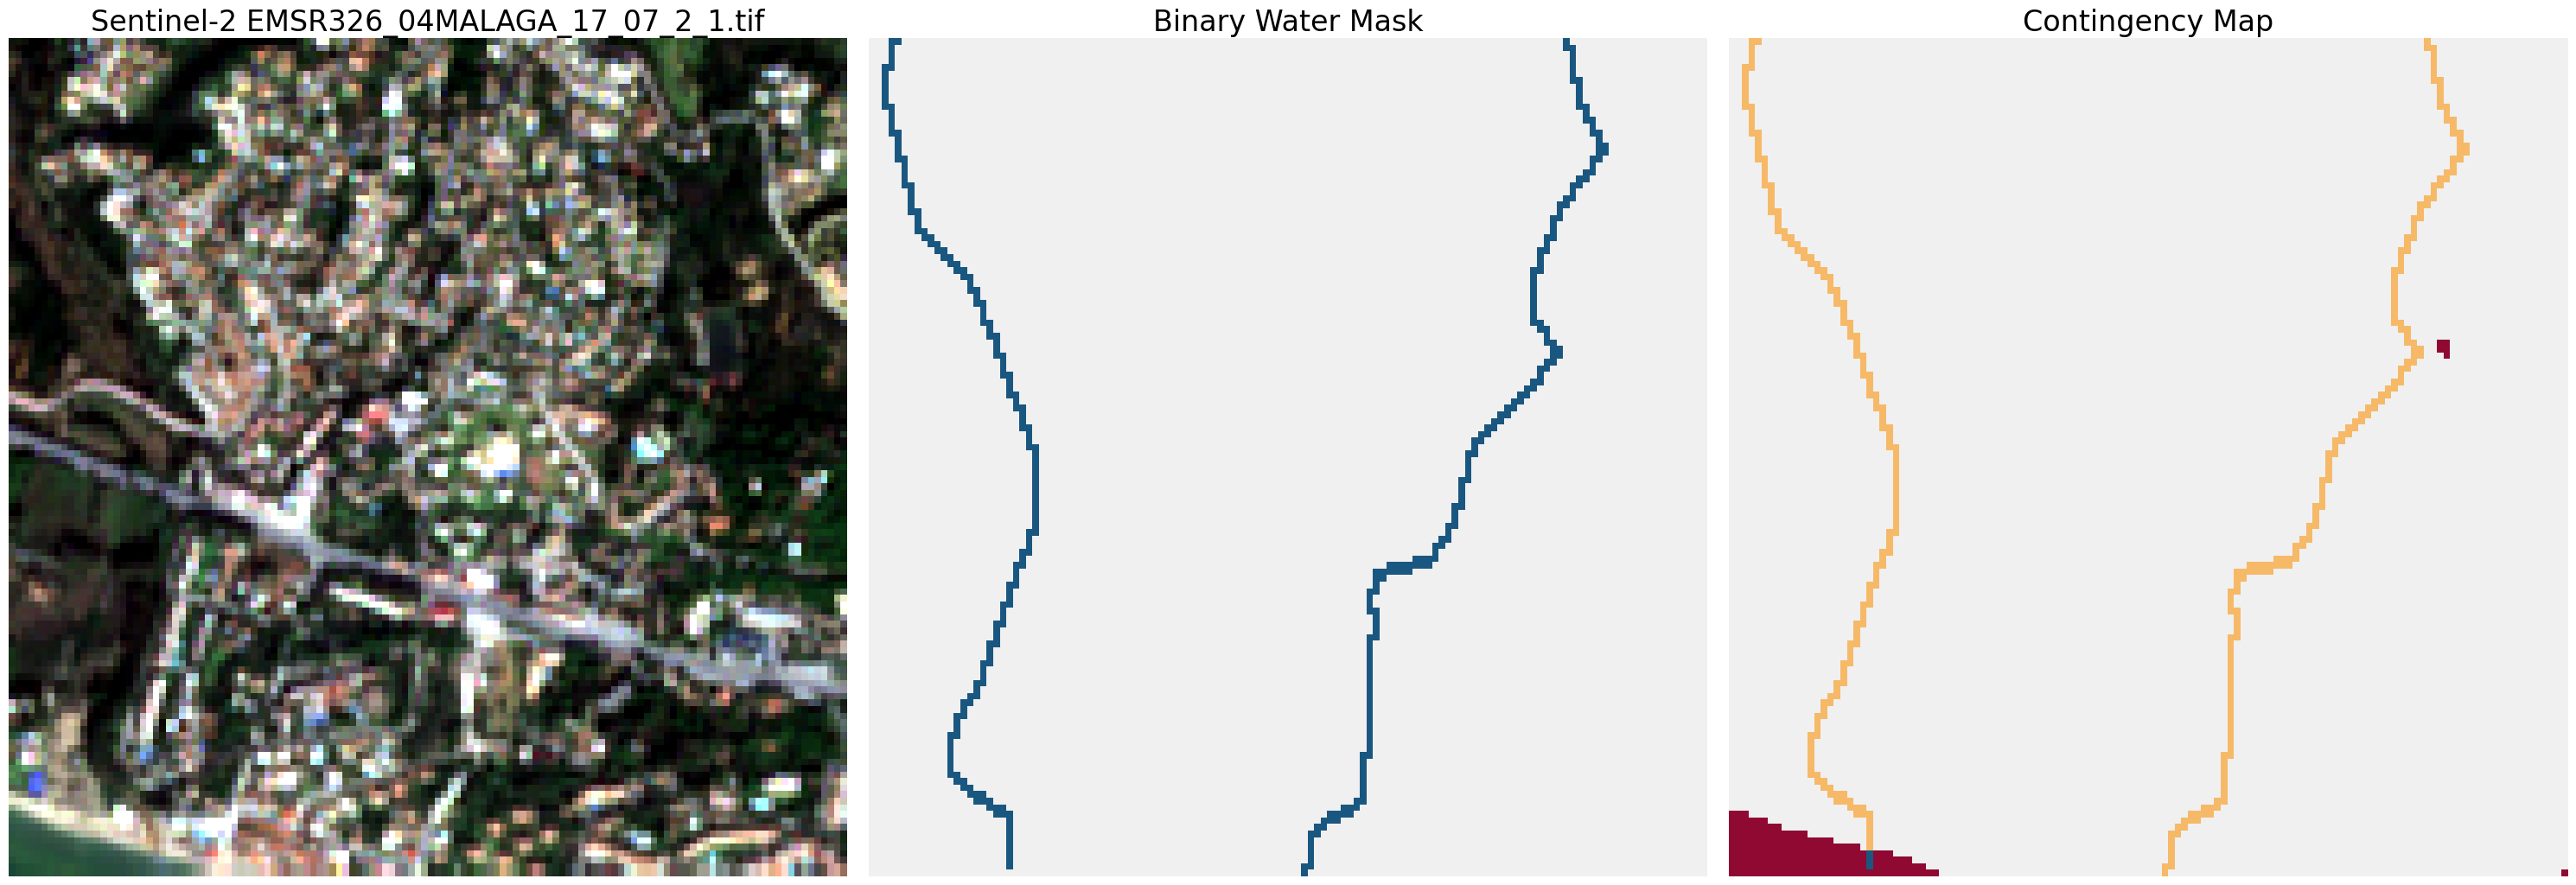

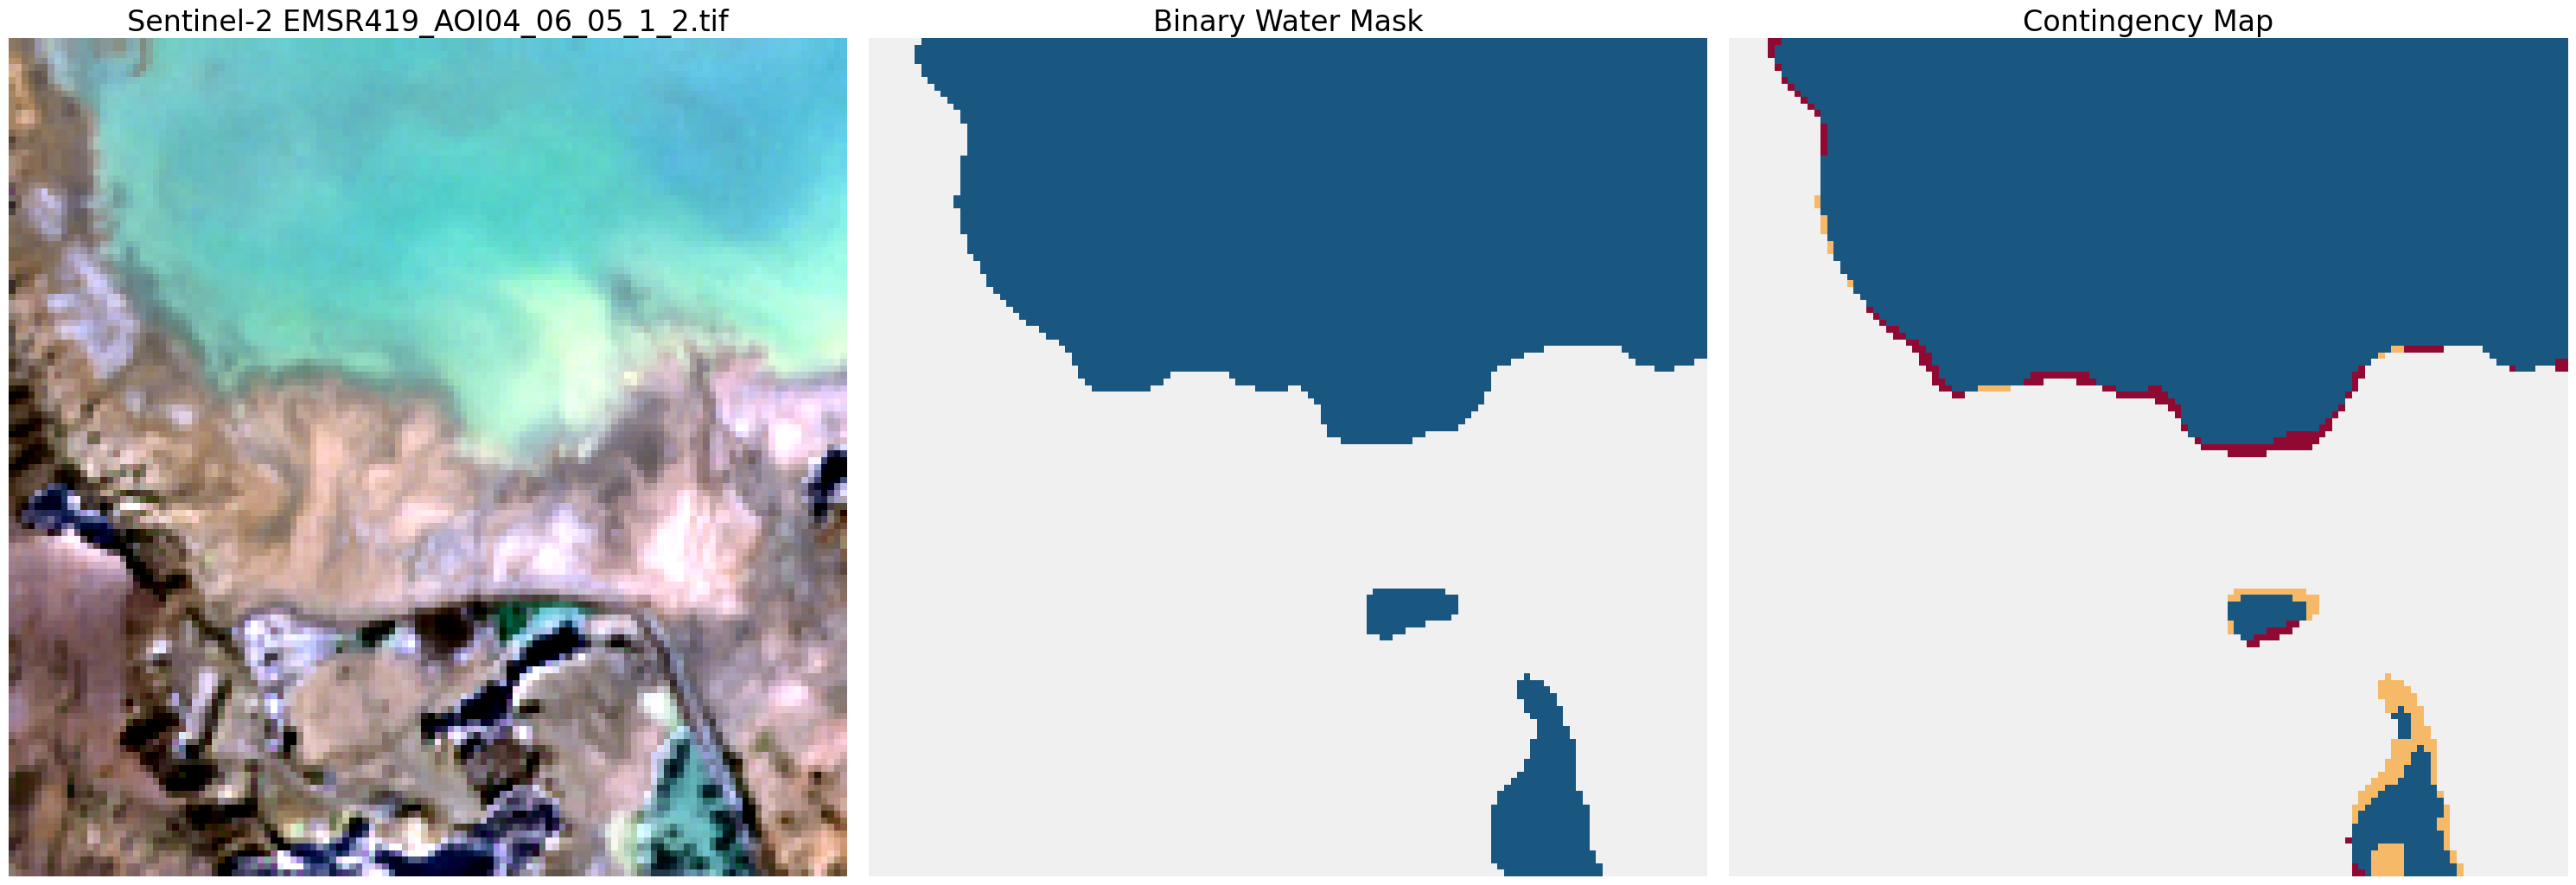

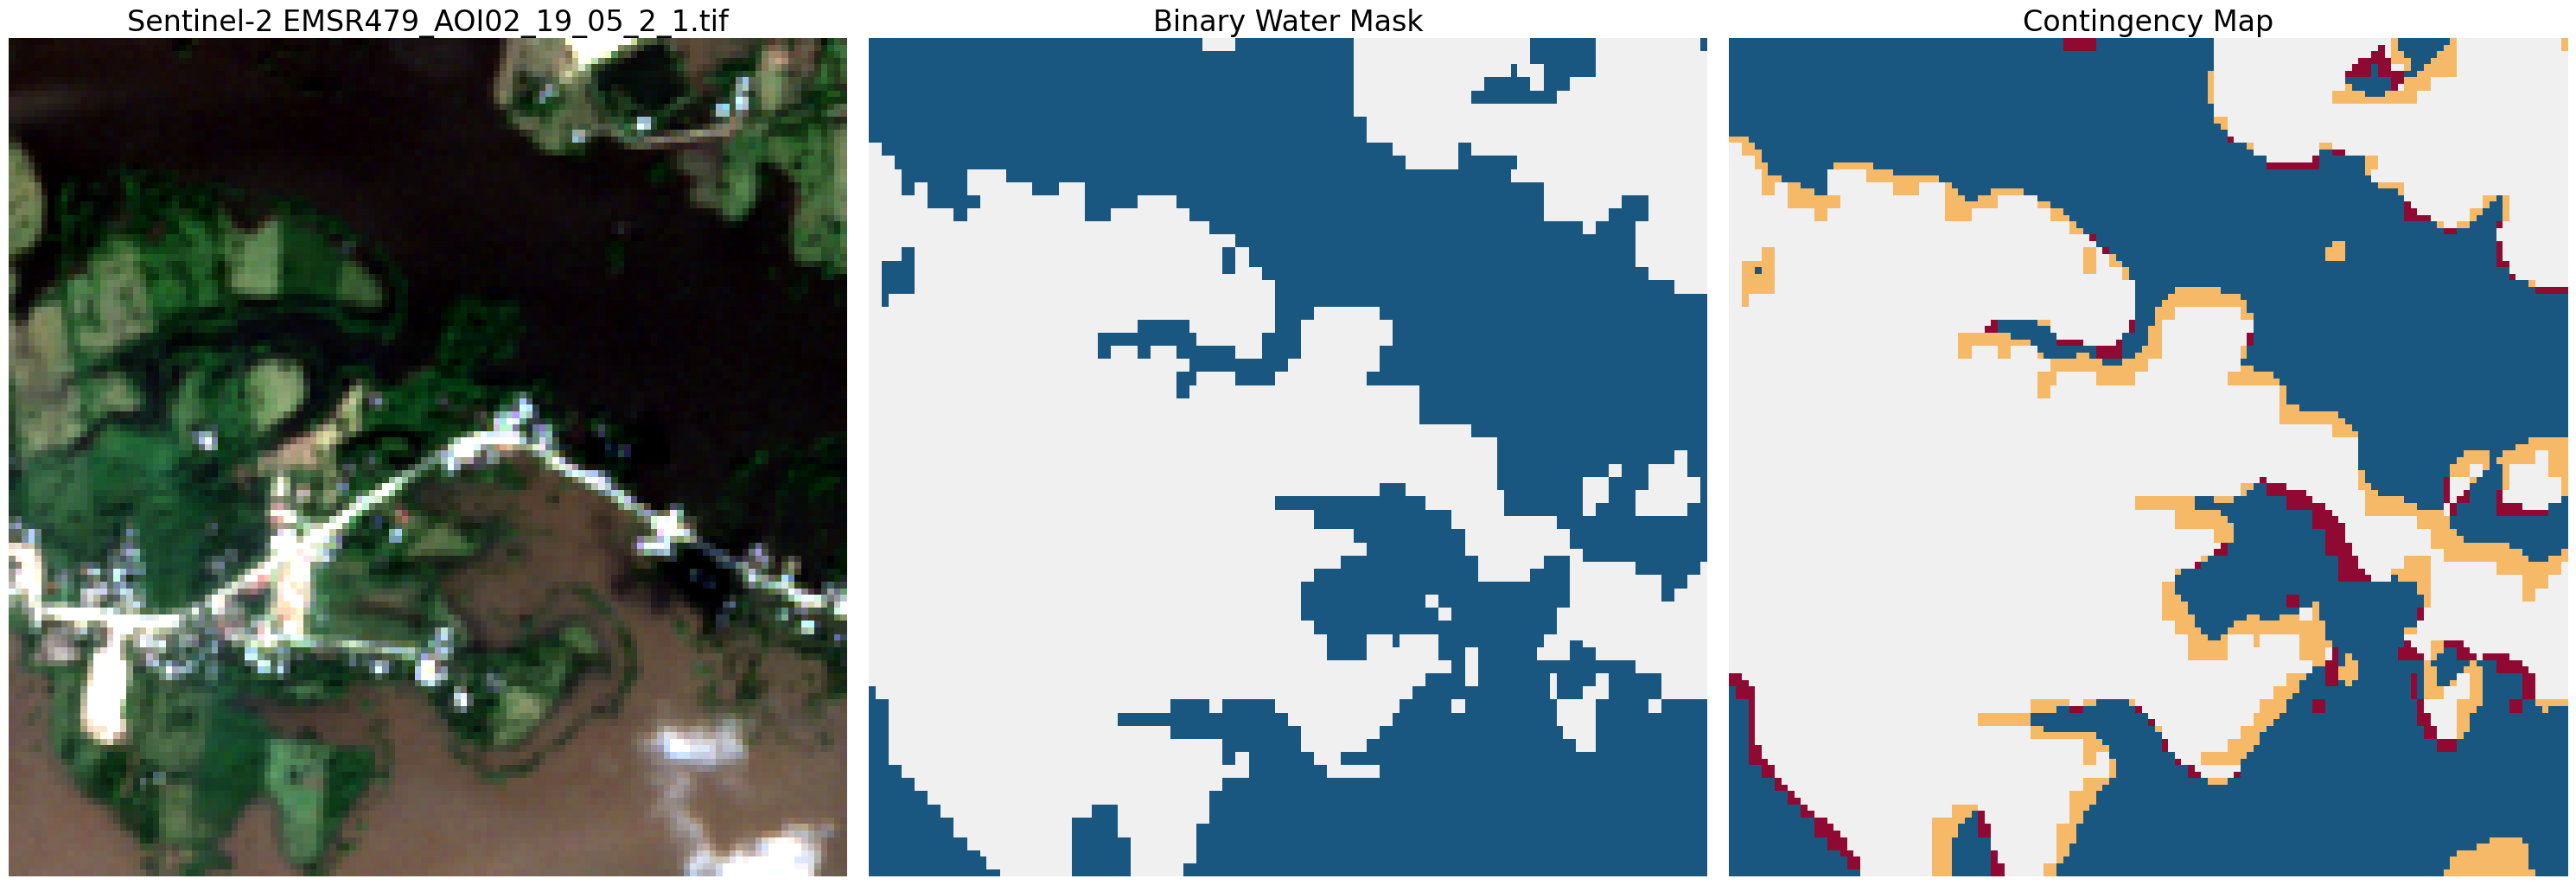

Visualizations saved to folder: ./tile_visualizations


In [11]:

# Save visualizations

if with_gt:
    # Save visualizations with GT
    save_visualizations(results_df[results_df['Dataset'] == 'Sentinel-1'],
                        'Sentinel-1', visualization_dir,composite_dirs, output_dir, mask_dirs, is_s2=False, with_gt=True, show_inline=True)
    save_visualizations(results_df[results_df['Dataset'] == 'Sentinel-2'],
                        'Sentinel-2', visualization_dir,composite_dirs, output_dir, mask_dirs, is_s2=True, with_gt=True, show_inline=True)
    print("Visualizations saved to folder:", visualization_dir)
else:
    # Save visualizations without GT
    save_visualizations(s1_test_df, 'Sentinel-1', visualization_dir, composite_dirs, output_dir, mask_dirs, is_s2=False, with_gt=False, show_inline=True,)
    save_visualizations(s2_test_df, 'Sentinel-2', visualization_dir, composite_dirs, output_dir, mask_dirs, is_s2=True, with_gt=False, show_inline=True,)
    print("Visualizations saved to folder:", visualization_dir)